**Author** : Jeonghhun Yoon
[This notebook](https://www.kaggle.com/artgor/elo-eda-and-models/notebook) is my references.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.offline as py
py.init_notebook_mode(connected=True)

import warnings
warnings.filterwarnings('ignore')
import os

In [2]:
pd.options.display.max_rows=None
pd.options.display.max_colwidth=100000

In [3]:
DIR_NAME = os.path.join(os.path.abspath('.'), 'inputs')
os.listdir(DIR_NAME)

['historical_transactions.csv',
 'merchants.csv',
 'new_merchant_transactions.csv',
 'test.csv',
 'train.csv',
 'Data_Dictionary.xlsx',
 'sample_submission.csv']

# 1. EDA & Data preprocessing

## train.csv

In [4]:
ex = pd.read_excel('./inputs/Data_Dictionary.xlsx', sheet_name='train')

In [5]:
ex

,train.csv,Unnamed: 1
0,NaN,NaN
1,Columns,Description
2,card_id,Unique card identifier
3,first_active_month,"'YYYY-MM', month of first purchase"
4,feature_1,Anonymized card categorical feature
5,feature_2,Anonymized card categorical feature
6,feature_3,Anonymized card categorical feature
7,target,Loyalty numerical score calculated 2 months after historical and evaluation period


In [6]:
train = pd.read_csv(os.path.join(DIR_NAME, 'train.csv'), parse_dates=['first_active_month'])

In [7]:
test = pd.read_csv(os.path.join(DIR_NAME, 'test.csv'), parse_dates=['first_active_month'])

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201917 entries, 0 to 201916
Data columns (total 6 columns):
first_active_month    201917 non-null datetime64[ns]
card_id               201917 non-null object
feature_1             201917 non-null int64
feature_2             201917 non-null int64
feature_3             201917 non-null int64
target                201917 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 9.2+ MB


In [9]:
train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913
2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.688056
3,2017-09-01,C_ID_186d6a6901,4,3,0,0.142495
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,-0.159749


### (1) Feature 1, 2, 3

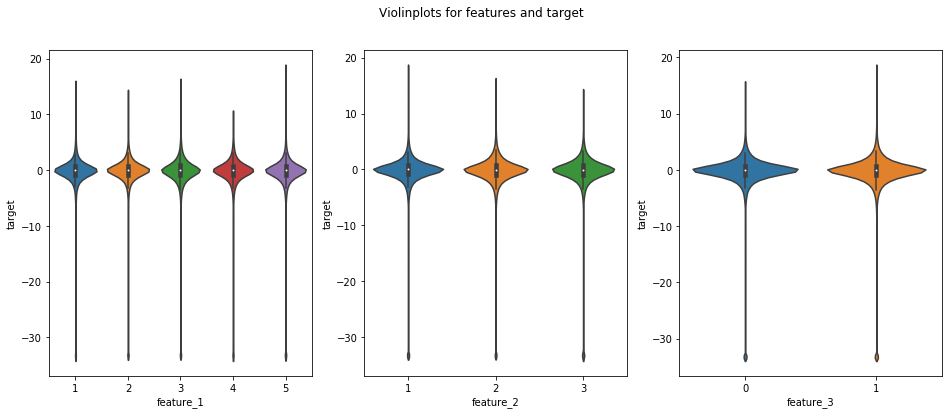

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(16, 6))
plt.suptitle("Violinplots for features and target")
sns.violinplot(x='feature_1', y='target', data=train, ax=ax[0], title='feature_1')
sns.violinplot(x='feature_2', y='target', data=train, ax=ax[1], title='feature_2')
sns.violinplot(x='feature_3', y='target', data=train, ax=ax[2], title='feature_3')

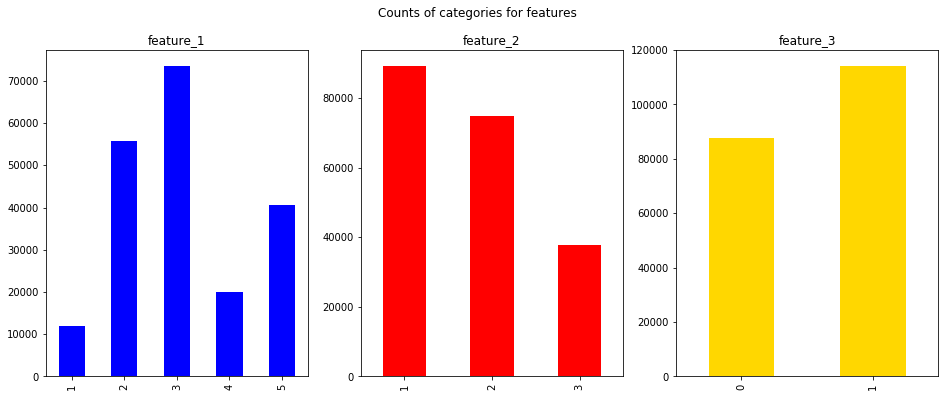

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(16,6))
plt.suptitle('Counts of categories for features')
train['feature_1'].value_counts().sort_index().plot(kind='bar', ax=ax[0], color='blue', title='feature_1')
train['feature_2'].value_counts().sort_index().plot(kind='bar', ax=ax[1], color='red', title='feature_2')
train['feature_3'].value_counts().sort_index().plot(kind='bar', ax=ax[2], color='gold', title='feature_3')

Counts of category could be different. But we can see in the violinplots, it could be that each category have same distribution to taget variables. So these features are not good at predictions of target variables. And the mean of distributions are 0 and the shape of distributions is bell-shape. So, it could be possible to come from normal distribution.

### (2) Date

In [12]:
d1 = train['first_active_month'].value_counts().sort_index()
d2 = test['first_active_month'].value_counts().sort_index()

In [13]:
data = [go.Scatter(x=d1.index, y=d1.values, name='train'), go.Scatter(x=d2.index, y=d2.values, name='test')]
layout = go.Layout(dict(title='Counts of first active', 
                        xaxis=dict(title='Month'), 
                        yaxis=dict(title='Count')), 
                   legend=dict(orientation='v'))
py.iplot(dict(data=data, layout=layout))

The usage of 2016~2017 is increasing steeply.

### (3) Target

Text(0.5, 0.98, 'Target distribution')

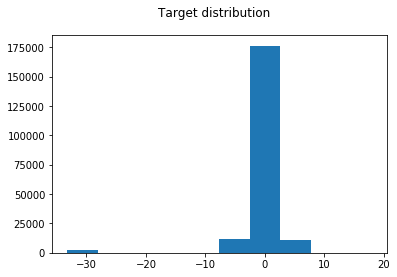

In [14]:
plt.hist(train['target'])
plt.suptitle('Target distribution')

In [15]:
len(train.loc[train.target < -20])

2207

In [16]:
train.loc[train.target < -20].head(10)

,first_active_month,card_id,feature_1,feature_2,feature_3,target
64,2017-09-01,C_ID_8186f3fcc1,3,1,1,-33.219281
92,2015-05-01,C_ID_b9379a30ea,3,3,1,-33.219281
125,2015-10-01,C_ID_e9120f535c,3,3,1,-33.219281
151,2017-03-01,C_ID_65715cb80d,4,2,0,-33.219281
225,2017-01-01,C_ID_ae77d244b6,2,1,0,-33.219281
248,2015-07-01,C_ID_c4262c902e,5,1,1,-33.219281
254,2017-03-01,C_ID_6a2c823e5f,2,1,0,-33.219281
386,2017-06-01,C_ID_98e1cb10b6,2,3,0,-33.219281
467,2017-03-01,C_ID_eb8175721a,4,1,0,-33.219281
515,2016-04-01,C_ID_a2580006bf,4,2,0,-33.219281


They are all same, it could be possible to come from fraud behavior.

### Feature engineering of `train.csv`

- Elapsed days

In [17]:
max_date = train['first_active_month'].dt.date.max()

def process_date(df):
    date_parts = ['year', 'weekday', 'month']
    for part in date_parts:
        part_col = 'first_active_month_{}'.format(part)
        # In test.csv has NaN first active month, so using float dtype.
        df[part_col] = getattr(df['first_active_month'].dt, part)
    df['elapsed_days'] = (max_date - df['first_active_month'].dt.date).dt.days
    
    return df

In [18]:
train = process_date(train)
test = process_date(test)

## historical_transaction.csv

In [19]:
ex1 = pd.read_excel('./inputs/Data_Dictionary.xlsx', sheet_name='history')

In [20]:
ex1

,historical_transactions.csv,Unnamed: 1
0,NaN,NaN
1,Columns,Description
2,card_id,Card identifier
3,month_lag,month lag to reference date
4,purchase_date,Purchase date
5,authorized_flag,"Y' if approved, 'N' if denied"
6,category_3,anonymized category
7,installments,number of installments of purchase
8,category_1,anonymized category
9,merchant_category_id,Merchant category identifier (anonymized )


In [21]:
historical_transactions = pd.read_csv('./inputs/historical_transactions.csv')

In [22]:
historical_transactions.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37


In [23]:
len(historical_transactions)

29112361

### (1) Authorized flag

In [24]:
historical_transactions['authorized_flag'] =\
    historical_transactions['authorized_flag'].apply(lambda x: 1 if x == 'Y' else 0)

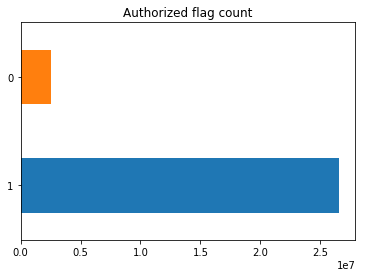

In [25]:
historical_transactions['authorized_flag'].value_counts().plot(kind='barh', title='Authorized flag count')

In [26]:
historical_transactions['authorized_flag'].mean()

0.9135450058482031

The average ratio of authorized transaction is 91%.

In [27]:
authorized_card_ratio =\
    historical_transactions.groupby(['card_id'])['authorized_flag'].mean().sort_values()

In [28]:
authorized_card_ratio.head()

card_id
C_ID_744d26ea32    0.030488
C_ID_bb8dd137c9    0.037037
C_ID_e56202cd39    0.042105
C_ID_4feacff118    0.050000
C_ID_c27b4f80f7    0.054545
Name: authorized_flag, dtype: float64

In [29]:
authorized_card_ratio.tail()

card_id
C_ID_d048b7cc60    1.0
C_ID_4e45fcdb43    1.0
C_ID_9f3ee1305e    1.0
C_ID_1b52a3e21b    1.0
C_ID_d3c3d988d5    1.0
Name: authorized_flag, dtype: float64

There are some cards, which are declined. It can be fraud transactions.

### (2) installments

In [30]:
historical_transactions['installments'].value_counts()

 0      15411747
 1      11677522
 2        666416
 3        538207
 4        179525
-1        178159
 6        132634
 10       118827
 5        116090
 12        55064
 8         20474
 7         10906
 9          5772
 11          830
 999         188
Name: installments, dtype: int64

-1 and 999 : We can consider these for filling missing values.

In [31]:
historical_transactions.groupby(['installments'])['authorized_flag'].mean().sort_values()

installments
 999    0.031915
 12     0.653694
 11     0.660241
 9      0.663721
 8      0.692439
 7      0.693196
 10     0.702021
 6      0.779732
 5      0.809183
 4      0.819903
 3      0.862254
 2      0.884020
-1      0.885692
 1      0.907024
 0      0.928032
Name: authorized_flag, dtype: float64

999 is for missing value, but it's authorized flag ratio is very low like outliers. So it could be fraud transactions comparing with -1.

### (3) Payment amounts

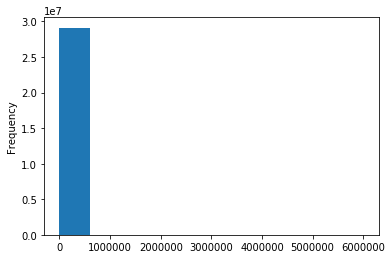

In [32]:
historical_transactions['purchase_amount'].plot(kind='hist')

In [33]:
for i in [-1, 0]:
    print(historical_transactions[historical_transactions['purchase_amount'] < i].shape[0])

0
28036884


In [34]:
for i in [0, 10, 100]:
    print(historical_transactions[historical_transactions['purchase_amount'] > i].shape[0])

1075467
14924
1183


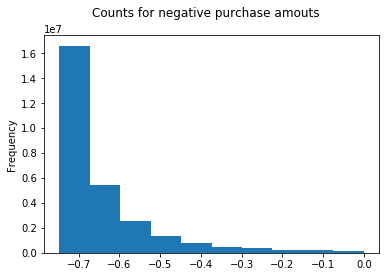

In [35]:
plt.suptitle('Counts for negative purchase amouts')
historical_transactions.loc[historical_transactions['purchase_amount'] < 0, 'purchase_amount'].plot(kind='hist')

### (4) categories

> Category 1

In [36]:
historical_transactions.category_1.value_counts()

N    27028332
Y     2084029
Name: category_1, dtype: int64

In [37]:
historical_transactions['category_1'] = \
    historical_transactions['category_1'].apply(lambda x: 1 if x == 'Y' else 0)

In [38]:
historical_transactions.groupby(['category_1']).agg({
    'purchase_amount': ['mean', 'std', 'count'], 'authorized_flag':['mean', 'std']
})

authorized_flag           purchase_amount                       
                      mean       std            mean          std     count
category_1                                                                 
0                 0.926265  0.261339        0.071540  1166.016045  27028332
1                 0.748578  0.433830       -0.419327    22.087594   2084029

0 of Category_1 is major of data. Authorized ratio is higher than 1 of Category_1. So Category_1 could effect the authorization of transactions.

> Category 2

In [39]:
historical_transactions.category_2.value_counts()

1.0    15177199
3.0     3911795
5.0     3725915
4.0     2618053
2.0     1026535
Name: category_2, dtype: int64

In [40]:
historical_transactions.groupby(['category_2']).agg({
    'purchase_amount': ['mean', 'std', 'count'], 'authorized_flag':['mean', 'std']
})

authorized_flag           purchase_amount                       
                      mean       std            mean          std     count
category_2                                                                 
1.0               0.927505  0.259306        0.149570  1548.714128  15177199
2.0               0.906225  0.291515       -0.165690    89.285770   1026535
3.0               0.918857  0.273055        0.180375   210.616100   3911795
4.0               0.927634  0.259094       -0.158951   141.945606   2618053
5.0               0.934260  0.247826       -0.104457   162.428785   3725915

All categories in Category_2 have quite similar authorization ratio.

> Category 3

In [41]:
historical_transactions.category_3.value_counts()

A    15411747
B    11677522
C     1844933
Name: category_3, dtype: int64

In [42]:
map_dict = {'A': 0, 'B': 1, 'C': 2, np.nan: 3}

In [43]:
historical_transactions['category_3'] = historical_transactions['category_3'].apply(lambda x: map_dict[x])

In [44]:
historical_transactions.groupby(['category_3']).agg({
    'purchase_amount': ['mean', 'std', 'count'],
    'authorized_flag': ['mean', 'std']
})

authorized_flag           purchase_amount                       
                      mean       std            mean          std     count
category_3                                                                 
0                 0.928032  0.258436        0.361926  1541.485188  15411747
1                 0.907024  0.290399       -0.404556   104.062692  11677522
2                 0.836498  0.369824        0.106023    24.047655   1844933
3                 0.885692  0.318186        0.058447     2.191567    178159

In [45]:
for col in ['city_id', 'merchant_category_id', 'merchant_id', 'state_id', 'subsector_id']:
    print('{}: {}'.format(col, historical_transactions[col].nunique()))

city_id: 308
merchant_category_id: 327
merchant_id: 326311
state_id: 25
subsector_id: 41


### Feature engineering for `historical_transactions.csv`

In [46]:
historical_transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29112361 entries, 0 to 29112360
Data columns (total 14 columns):
authorized_flag         int64
card_id                 object
city_id                 int64
category_1              int64
installments            int64
category_3              int64
merchant_category_id    int64
merchant_id             object
month_lag               int64
purchase_amount         float64
purchase_date           object
category_2              float64
state_id                int64
subsector_id            int64
dtypes: float64(2), int64(9), object(3)
memory usage: 3.0+ GB


In [47]:
import datetime

In [48]:
def aggregate_historical_transactions(trans, prefix):
    # Purchase date
    trans['purchase_year'] = trans['purchase_date'].dt.year
    trans['purchase_month'] = trans['purchase_date'].dt.month
    trans['purchase_weekofyear'] = trans['purchase_date'].dt.weekofyear
    trans['purchase_dayofweek'] = trans['purchase_date'].dt.dayofweek
    trans['purchase_hour'] = trans['purchase_date'].dt.hour
    trans['is_weekend_purchase'] = (trans['purchase_dayofweek'] >= 5).astype(int)
    trans['purchase_diff'] = (datetime.datetime.today() - trans['purchase_date']).dt.days / 30
    trans['purchase_diff'] += trans['month_lag']
    trans.loc[:, 'purchase_date'] = pd.DatetimeIndex(trans['purchase_date'])\
        .astype(np.int64) * 1e-9
    # Installments
    trans['installments'] = trans['installments'].astype(int)
    # Category
    trans = pd.get_dummies(trans, columns = ['category_2', 'category_3'])
    agg_func = {
        'authorized_flag': ['sum', 'mean'],
        'category_1': ['sum', 'mean'],
        'category_2_1.0': ['sum', 'mean'],
        'category_2_2.0': ['sum', 'mean'],
        'category_2_3.0': ['sum', 'mean'],
        'category_2_4.0': ['sum', 'mean'],
        'category_2_5.0': ['sum', 'mean'],
        'category_3_0':['sum', 'mean'],
        'category_3_1':['sum', 'mean'],
        'category_3_2':['sum', 'mean'],
        'merchant_id': ['nunique'],
        'purchase_amount': ['sum', 'max', 'min', 'mean', 'std'],
        'installments': ['sum', 'max', 'min', 'mean', 'std'],
        'purchase_month': ['max', 'min', 'mean', 'std'],
        'purchase_date': ['max', 'min', 'mean', 'std'],
        'month_lag': ['min', 'max'],
        'merchant_category_id': ['nunique'],
        'state_id': ['nunique'],
        'subsector_id': ['nunique'],
        'city_id': ['nunique']
    }
    agg_trans = trans.groupby(['card_id']).agg(agg_func)
    agg_trans.columns = [prefix + '_'.join(col).strip() for col in agg_trans.columns.values]
    agg_trans.reset_index(inplace=True)
    
    df = (trans.groupby('card_id').size().reset_index(name='{}_transactions_count'.format(prefix)))
    
    agg_trans = df.merge(agg_trans, on='card_id', how='left')
    
    return agg_trans

In [49]:
def aggregate_per_month(trans):
    trans['installments'] = trans['installments'].astype(int)
    agg_func = {
        'installments': ['mean', 'min', 'max', 'std', 'count', 'sum'],
        'purchase_amount': ['mean', 'min', 'max', 'std', 'count', 'sum']
    }
    intermediate_group = trans.groupby(['card_id', 'month_lag']).agg(agg_func)
    intermediate_group.columns = ['_'.join(col).strip() for col in intermediate_group.columns.values]
    intermediate_group.reset_index(inplace=True)
    
    final_group = intermediate_group.groupby(['card_id']).agg(['mean', 'std'])
    final_group.columns = ['_'.join(col).strip() for col in final_group.columns.values]
    final_group.reset_index(inplace=True)
    
    return final_group

In [50]:
final_group = aggregate_per_month(historical_transactions)

In [51]:
final_group.head()

,card_id,month_lag_mean,month_lag_std,purchase_amount_mean_mean,purchase_amount_mean_std,purchase_amount_min_mean,purchase_amount_min_std,purchase_amount_max_mean,purchase_amount_max_std,purchase_amount_std_mean,...,installments_min_mean,installments_min_std,installments_max_mean,installments_max_std,installments_std_mean,installments_std_std,installments_count_mean,installments_count_std,installments_sum_mean,installments_sum_std
0,C_ID_00007093c1,-6.000000,3.894440,-0.507947,0.097299,-0.704152,0.041908,-0.027161,0.523539,0.228582,...,1.000000,0.000000,2.615385,1.556624,0.625616,0.609378,11.461538,4.701336,14.769231,6.431094
1,C_ID_0001238066,-2.500000,1.870829,-0.603204,0.045861,-0.730351,0.002699,-0.160977,0.485869,0.150340,...,0.666667,0.816497,4.666667,2.875181,1.246996,0.507930,20.500000,12.275993,33.000000,25.226970
2,C_ID_0001506ef0,-6.230769,4.225988,-0.461749,0.259737,-0.725724,0.011212,0.161333,0.748701,0.478896,...,0.000000,0.000000,0.076923,0.277350,0.034021,0.117851,5.076923,4.536179,0.076923,0.277350
3,C_ID_0001793786,-4.500000,3.027650,-0.042211,0.277565,-0.647028,0.166706,2.190924,1.290775,0.851430,...,0.000000,0.000000,0.300000,0.483046,0.065065,0.105721,21.600000,13.969809,0.500000,0.849837
4,C_ID_000183fdda,-3.000000,2.160247,-0.425378,0.214361,-0.687901,0.107543,1.034983,1.018223,0.462838,...,0.428571,0.975900,8.714286,2.214670,2.173750,0.618504,20.571429,9.198861,37.714286,15.445758


In [52]:
%%time
historical_transactions['purchase_date'] = historical_transactions['purchase_date'].astype('datetime64')
history = aggregate_historical_transactions(historical_transactions, prefix='hist_')

CPU times: user 2min 39s, sys: 32 s, total: 3min 10s
Wall time: 3min 10s


In [53]:
train = pd.merge(train, history, on='card_id', how='left')
test = pd.merge(test, history, on='card_id', how='left')

## new_merchant_transactions.csv

In [54]:
new_merchant_transactions = pd.read_csv('./inputs/new_merchant_transactions.csv', parse_dates=['purchase_date'])

In [55]:
ex3 = pd.read_excel('./inputs/Data_Dictionary.xlsx', sheet_name='new_merchant_period')

In [56]:
ex3

,new_merchant_period.csv,Unnamed: 1
0,NaN,NaN
1,Columns,Description
2,card_id,Card identifier
3,month_lag,month lag to reference date
4,purchase_date,Purchase date
5,authorized_flag,"Y' if approved, 'N' if denied"
6,category_3,anonymized category
7,installments,number of installments of purchase
8,category_1,anonymized category
9,merchant_category_id,Merchant category identifier (anonymized )


In [57]:
new_merchant_transactions.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_415bb3a509,107,N,1,B,307,M_ID_b0c793002c,1,-0.557574,2018-03-11 14:57:36,1.0,9,19
1,Y,C_ID_415bb3a509,140,N,1,B,307,M_ID_88920c89e8,1,-0.569580,2018-03-19 18:53:37,1.0,9,19
2,Y,C_ID_415bb3a509,330,N,1,B,507,M_ID_ad5237ef6b,2,-0.551037,2018-04-26 14:08:44,1.0,9,14
3,Y,C_ID_415bb3a509,-1,Y,1,B,661,M_ID_9e84cda3b1,1,-0.671925,2018-03-07 09:43:21,NaN,-1,8
4,Y,C_ID_ef55cf8d4b,-1,Y,1,B,166,M_ID_3c86fa3831,1,-0.659904,2018-03-22 21:07:53,NaN,-1,29


### (1) Authorized flag

In [58]:
new_merchant_transactions['authorized_flag'].value_counts()

Y    1963031
Name: authorized_flag, dtype: int64

In [59]:
new_merchant_transactions['authorized_flag'] = \
    new_merchant_transactions['authorized_flag'].apply(lambda x: 1 if x == 'Y' else 0)

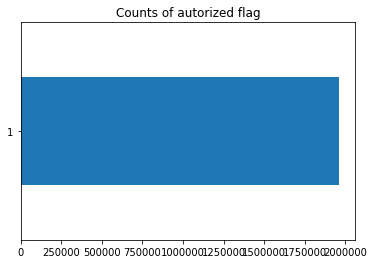

In [60]:
new_merchant_transactions['authorized_flag'].value_counts() \
    .plot(kind='barh', title='Counts of autorized flag')

All cards are authorized.

### (2) Purchase amount

In [61]:
card_total_purchase = new_merchant_transactions.groupby(['card_id'])['purchase_amount'].sum().sort_values()

In [62]:
card_total_purchase.head()

card_id
C_ID_b7ebee6539   -70.813489
C_ID_8946508722   -63.907274
C_ID_c729288535   -61.042650
C_ID_6cef1dba4b   -60.780407
C_ID_0e4f6af077   -60.017000
Name: purchase_amount, dtype: float64

In [63]:
card_total_purchase.tail()

card_id
C_ID_72613043cf    109.086210
C_ID_01314ceccf    113.317420
C_ID_a9435eee72    145.168997
C_ID_a289e7edd4    172.182653
C_ID_ca850ecf25    263.157498
Name: purchase_amount, dtype: float64

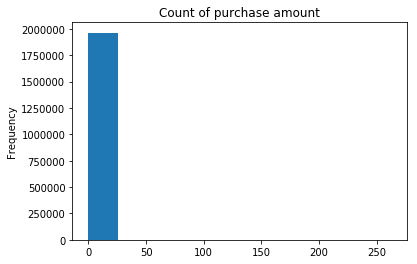

In [64]:
new_merchant_transactions['purchase_amount'].plot(kind='hist', title='Count of purchase amount')

In [65]:
for i in [-1, 0]:
    print('{} : {}' \
          .format(i, new_merchant_transactions.loc[new_merchant_transactions['purchase_amount'] < i].shape[0]))
for i in [0, 10, 100]:
    print('{} : {}' \
          .format(i, new_merchant_transactions.loc[new_merchant_transactions['purchase_amount'] > i].shape[0]))

-1 : 0
0 : 1877357
0 : 85674
10 : 996
100 : 2


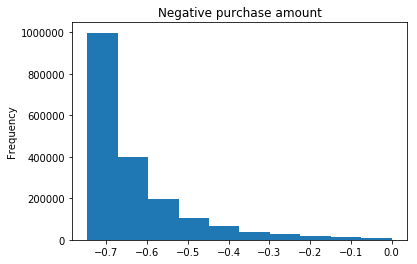

In [66]:
new_merchant_transactions.loc[new_merchant_transactions['purchase_amount'] < 0, 'purchase_amount']\
    .plot(kind='hist', title='Negative purchase amount')

### (3) Installments

In [67]:
new_merchant_transactions['installments'].value_counts()

 0      922244
 1      836178
-1       55922
 2       54729
 3       44750
 4       14815
 6       10389
 5        9296
 10       8899
 12       2850
 8        1555
 7         863
 9         478
 11         61
 999         2
Name: installments, dtype: int64

-1 : for nan values

In [68]:
new_merchant_transactions.groupby(['installments'])['purchase_amount'].sum()

installments
-1        1903.176718
 0     -581948.746520
 1     -507130.345871
 2      -21592.186709
 3       -6669.938153
 4        3212.909351
 5        2641.835005
 6        6994.802878
 7         522.470989
 8        1927.359352
 9         958.387496
 10      13864.551233
 11        117.734959
 12       3627.758765
 999         1.005048
Name: purchase_amount, dtype: float64

### (4) Categories

> Category_1

In [69]:
new_merchant_transactions.category_1.value_counts()

N    1899935
Y      63096
Name: category_1, dtype: int64

In [70]:
new_merchant_transactions['category_1'] = new_merchant_transactions['category_1']\
    .apply(lambda x: 1 if x == 'Y' else 0)
new_merchant_transactions.groupby(['category_1']).agg({'purchase_amount': ['mean', 'std']})

purchase_amount          
                      mean       std
category_1                          
0                -0.562004  0.648799
1                -0.218671  1.481696

> Category_2

In [71]:
new_merchant_transactions.category_2.value_counts()

1.0    1058242
3.0     289525
5.0     259266
4.0     178590
2.0      65663
Name: category_2, dtype: int64

In [72]:
new_merchant_transactions.groupby(['category_2']).agg({
    'purchase_amount': ['mean', 'std', 'count'], 'authorized_flag':['mean', 'std']
})

authorized_flag      purchase_amount                   
                      mean  std            mean       std    count
category_2                                                        
1.0                      1  0.0       -0.569242  0.673693  1058242
2.0                      1  0.0       -0.555640  0.542029    65663
3.0                      1  0.0       -0.550852  0.612882   289525
4.0                      1  0.0       -0.557578  0.600636   178590
5.0                      1  0.0       -0.549015  0.654138   259266

> Category_3

In [73]:
new_merchant_transactions.category_3.value_counts()

A    922244
B    836178
C    148687
Name: category_3, dtype: int64

In [74]:
map_dict = {'A': 0, 'B': 1, 'C': 2, np.nan: 3}
new_merchant_transactions['category_3'] = new_merchant_transactions['category_3'].apply(lambda x: map_dict[x])

In [75]:
new_merchant_transactions.groupby(['category_3']).agg({
    'purchase_amount': ['mean', 'std', 'count'],
    'authorized_flag': ['mean', 'std']
})

authorized_flag      purchase_amount                  
                      mean  std            mean       std   count
category_3                                                       
0                        1  0.0       -0.631014  0.268039  922244
1                        1  0.0       -0.606486  0.443664  836178
2                        1  0.0        0.037708  1.787946  148687
3                        1  0.0        0.034033  1.692377   55922

In [76]:
for col in ['city_id', 'merchant_category_id', 'merchant_id', 'state_id', 'subsector_id']:
    print('{}: {}'.format(col, new_merchant_transactions[col].nunique()))

city_id: 308
merchant_category_id: 314
merchant_id: 226129
state_id: 25
subsector_id: 41


### Feature engineering for `new_merchant_transactions.csv`

In [77]:
%%time
new_merchant_transactions['purchase_date'] = new_merchant_transactions['purchase_date'].astype('datetime64')
history = aggregate_historical_transactions(new_merchant_transactions, prefix='new_')

CPU times: user 10.5 s, sys: 1.18 s, total: 11.6 s
Wall time: 11.6 s


In [78]:
train = pd.merge(train, history, on='card_id', how='left')
test = pd.merge(test, history, on='card_id', how='left')

`final_group` from historical transaction.

In [79]:
train = pd.merge(train, final_group, on='card_id')
test = pd.merge(test, final_group, on='card_id')

In [80]:
pd.options.display.max_columns=None
train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target,first_active_month_year,first_active_month_weekday,first_active_month_month,elapsed_days,hist__transactions_count,hist_authorized_flag_sum,hist_authorized_flag_mean,hist_category_2_2.0_sum,hist_category_2_2.0_mean,hist_purchase_amount_sum,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_mean,hist_purchase_amount_std,hist_installments_sum,hist_installments_max,hist_installments_min,hist_installments_mean,hist_installments_std,hist_category_2_3.0_sum,hist_category_2_3.0_mean,hist_category_3_2_sum,hist_category_3_2_mean,hist_purchase_month_max,hist_purchase_month_min,hist_purchase_month_mean,hist_purchase_month_std,hist_category_3_0_sum,hist_category_3_0_mean,hist_merchant_id_nunique,hist_merchant_category_id_nunique,hist_category_2_4.0_sum,hist_category_2_4.0_mean,hist_city_id_nunique,hist_category_3_1_sum,hist_category_3_1_mean,hist_purchase_date_max,hist_purchase_date_min,hist_purchase_date_mean,hist_purchase_date_std,hist_subsector_id_nunique,hist_category_1_sum,hist_category_1_mean,hist_category_2_1.0_sum,hist_category_2_1.0_mean,hist_category_2_5.0_sum,hist_category_2_5.0_mean,hist_state_id_nunique,hist_month_lag_min,hist_month_lag_max,new__transactions_count,new_authorized_flag_sum,new_authorized_flag_mean,new_category_2_2.0_sum,new_category_2_2.0_mean,new_purchase_amount_sum,new_purchase_amount_max,new_purchase_amount_min,new_purchase_amount_mean,new_purchase_amount_std,new_installments_sum,new_installments_max,new_installments_min,new_installments_mean,new_installments_std,new_category_2_3.0_sum,new_category_2_3.0_mean,new_category_3_2_sum,new_category_3_2_mean,new_purchase_month_max,new_purchase_month_min,new_purchase_month_mean,new_purchase_month_std,new_category_3_0_sum,new_category_3_0_mean,new_merchant_id_nunique,new_merchant_category_id_nunique,new_category_2_4.0_sum,new_category_2_4.0_mean,new_city_id_nunique,new_category_3_1_sum,new_category_3_1_mean,new_purchase_date_max,new_purchase_date_min,new_purchase_date_mean,new_purchase_date_std,new_subsector_id_nunique,new_category_1_sum,new_category_1_mean,new_category_2_1.0_sum,new_category_2_1.0_mean,new_category_2_5.0_sum,new_category_2_5.0_mean,new_state_id_nunique,new_month_lag_min,new_month_lag_max,month_lag_mean,month_lag_std,purchase_amount_mean_mean,purchase_amount_mean_std,purchase_amount_min_mean,purchase_amount_min_std,purchase_amount_max_mean,purchase_amount_max_std,purchase_amount_std_mean,purchase_amount_std_std,purchase_amount_count_mean,purchase_amount_count_std,purchase_amount_sum_mean,purchase_amount_sum_std,installments_mean_mean,installments_mean_std,installments_min_mean,installments_min_std,installments_max_mean,installments_max_std,installments_std_mean,installments_std_std,installments_count_mean,installments_count_std,installments_sum_mean,installments_sum_std
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283,2017,3,6,245,260,247,0.950000,0.0,0.0,-165.968739,2.258395,-0.739395,-0.638341,0.212139,4,1,0,0.015385,0.123314,0.0,0.0,0.0,0.000000,12,1,8.057692,3.474193,256.0,0.984615,94,41,0.0,0.000000,7,4.0,0.015385,1.519551e+09,1.498573e+09,1.508362e+09,6.414828e+06,21,0,0.000000,257.0,0.988462,3.0,0.011538,3,-8,0,23.0,23.0,1.0,0.0,0.0,-13.244202,-0.296112,-0.724368,-0.575835,0.135812,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,4.0,3.0,3.478261,0.510754,23.0,1.0,23.0,14.0,0.0,0.000000,3.0,0.0,0.000000,1.525001e+09,1.520259e+09,1.522525e+09,1.432664e+06,10.0,0.0,0.000000,23.0,1.000000,0.0,0.0,1.0,1.0,2.0,-4.000000,2.738613,-0.650518,0.049922,-0.732686,0.008797,-0.158815,0.916015,0.109641,0.117152,28.888889,17.244162,-18.440971,10.472169,0.018182,0.032221,0.000000,0.000000,0.333333,0.500000,0.074290,0.117067,28.888889,17.244162,0.444444,0.726483
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913,2017,6,1,396,350,339,0.968571,0.0,0.0,-210.006336,4.630299,-0.742400,-0.600018,0.384967,543,10,-1,1.551429,1.510777,0.0,0.0,72.0,0.205714,12,1,6.220000,3.848142,0.0,0.00000

## merchants.csv

In [81]:
merchants = pd.read_csv('./inputs/merchants.csv')

In [82]:
ex4 = pd.read_excel('./inputs/Data_Dictionary.xlsx', sheet_name='merchant')

In [83]:
ex4

,merchants.csv,Unnamed: 1
0,NaN,NaN
1,Columns,Description
2,merchant_id,Unique merchant identifier
3,merchant_group_id,Merchant group (anonymized )
4,merchant_category_id,Unique identifier for merchant category (anonymized )
5,subsector_id,Merchant category group (anonymized )
6,numerical_1,anonymized measure
7,numerical_2,anonymized measure
8,category_1,anonymized category
9,most_recent_sales_range,Range of revenue (monetary units) in last active month --> A > B > C > D > E


### (1) Numerical 1

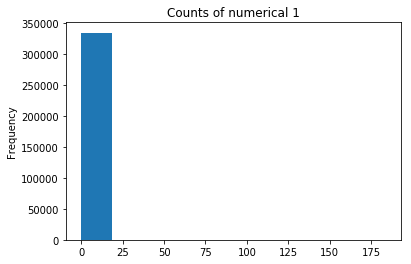

In [84]:
merchants.numerical_1.plot(kind='hist', title='Counts of numerical 1')

In [85]:
np.percentile(merchants.numerical_1, 95)

0.09125291

95% of numerical_1 are smaller than 0.0912

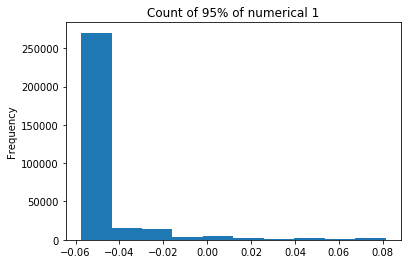

In [86]:
merchants.loc[merchants['numerical_1'] < 0.09, 'numerical_1'].plot(kind='hist', title='Count of 95% of numerical 1')

In [87]:
min_num_1 = merchants['numerical_1'].min()
sum(merchants['numerical_1'] == min_num_1) / merchants.shape[0]

0.68356956760762

As we can see, the ratio of minimum value is 0.68. This features have very skewed distribution.

### (2) Numerical 2

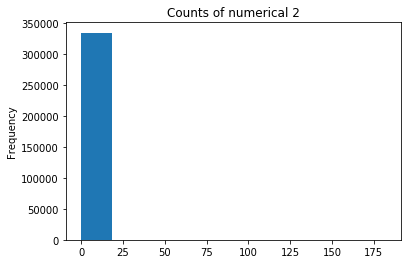

In [88]:
merchants.numerical_2.plot(kind='hist', title='Counts of numerical 2')

In [ ]:
np.percentile(merchants.numerical_2, 95)

0.08133801

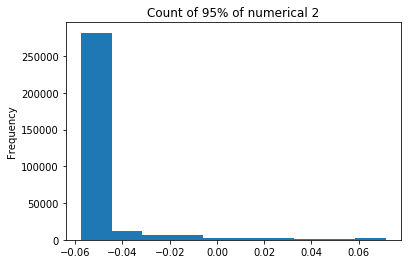

In [ ]:
merchants.loc[merchants['numerical_2'] < 0.08, 'numerical_2'].plot(kind='hist', title='Count of 95% of numerical 2')

In [ ]:
min_num_2 = merchants['numerical_2'].min()
sum(merchants['numerical_2'] == min_num_2) / merchants.shape[0]

0.7431041900709898

Numeric_2 is very simiral to numeric_1.

In [ ]:
sum(merchants['numerical_1'] != merchants['numerical_2']) / merchants.shape[0]

0.10056289886942181

90% of numerical_1 and numerical_2 are same.

### (3) Most recent sales ranges

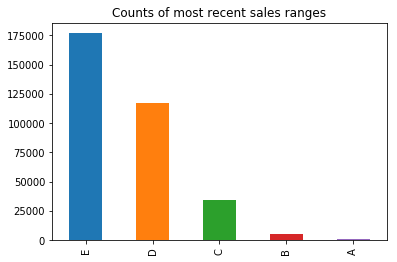

In [ ]:
merchants.most_recent_sales_range.value_counts().plot(kind='bar', title='Counts of most recent sales ranges')

In [ ]:
d = merchants['most_recent_sales_range'].value_counts().sort_index()
e = merchants.loc[merchants['numerical_1'] < 0.1].groupby(['most_recent_sales_range'])['numerical_1'].mean()
data = [go.Bar(x=d.index, y=d.values, name='counts'), 
        go.Scatter(x=e.index, y=e.values, name='mean numerical 1', yaxis='y2')]
layout = go.Layout(
    dict(title='Counts of values in categories of most_recent_sales_ranges', 
         xaxis=dict(title='most recent sales ranges'),
         yaxis=dict(title='Counts'),
         yaxis2=dict(title='mean values of numerical 1',
                     overlaying='y',
                     side='right'),
         legend=dict(orientation='v'))
)
py.iplot(dict(data=data, layout=layout))

We can see that these ranges has different ranges after removing outliers.

In [ ]:
d = merchants['most_recent_sales_range'].value_counts().sort_index()
e = merchants.loc[merchants['numerical_2'] < 0.1].groupby(['most_recent_sales_range'])['numerical_2'].mean()
data = [go.Bar(x=d.index, y=d.values, name='counts'), 
        go.Scatter(x=e.index, y=e.values, name='mean numerical 2', yaxis='y2')]
layout = go.Layout(
    dict(title='Counts of values in categories of most_recent_sales_ranges', 
         xaxis=dict(title='most recent sales ranges'),
         yaxis=dict(title='Counts'),
         yaxis2=dict(title='mean values of numerical 2',
                     overlaying='y',
                     side='right'),
         legend=dict(orientation='v'))
)
py.iplot(dict(data=data, layout=layout))

### (4) Average sales lag 3, 6, 12

In [ ]:
for col in ['avg_sales_lag3', 'avg_sales_lag6', 'avg_sales_lag12']:
    print(col, 'min', merchants[col].min())
    print(col, 'max', merchants[col].max())

avg_sales_lag3 min -82.13
avg_sales_lag3 max 851844.64
avg_sales_lag6 min -82.13
avg_sales_lag6 max 1513959.0
avg_sales_lag12 min -82.13
avg_sales_lag12 max 2567408.0


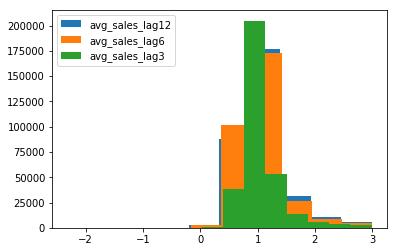

In [ ]:
plt.hist(merchants.loc[(merchants['avg_sales_lag12'] < 3) & (merchants['avg_sales_lag12'] > -10), 'avg_sales_lag12'].fillna(0), label='avg_sales_lag12')
plt.hist(merchants.loc[(merchants['avg_sales_lag6'] < 3) & (merchants['avg_sales_lag6'] > -10), 'avg_sales_lag6'].fillna(0), label='avg_sales_lag6')
plt.hist(merchants.loc[(merchants['avg_sales_lag3'] < 3) & (merchants['avg_sales_lag3'] > -10), 'avg_sales_lag3'].fillna(0), label='avg_sales_lag3')
plt.legend()

The distributions are sames between 0 and 2.

### (5) Averages purchase lag 3, 6, 12

In [ ]:
merchants['avg_purchases_lag3'].nlargest()

10                inf
11                inf
12                inf
235      6.185133e+04
13168    1.730000e+03
Name: avg_purchases_lag3, dtype: float64

In [ ]:
merchants.loc[merchants['avg_purchases_lag12'] == np.inf, 'avg_purchases_lag12'] = 6000
merchants.loc[merchants['avg_purchases_lag6'] == np.inf, 'avg_purchases_lag6'] = 6000
merchants.loc[merchants['avg_purchases_lag3'] == np.inf, 'avg_purchases_lag3'] = 6000

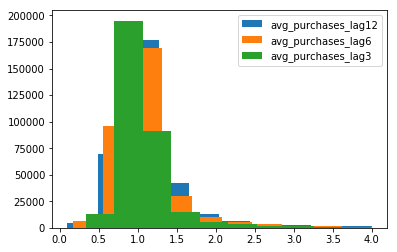

In [ ]:
plt.hist(merchants.loc[(merchants['avg_purchases_lag12'] < 4, 'avg_purchases_lag12')].fillna(0), label='avg_purchases_lag12')
plt.hist(merchants.loc[(merchants['avg_purchases_lag6'] < 4, 'avg_purchases_lag6')].fillna(0), label='avg_purchases_lag6')
plt.hist(merchants.loc[(merchants['avg_purchases_lag3'] < 4, 'avg_purchases_lag3')].fillna(0), label='avg_purchases_lag3')
plt.legend()

We will not use meerchants data yet.

# 2. Modeling

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import xgboost as xgb
import catboost as cat
import time

### 1. Filling NaN values and encoding

In [ ]:
train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target,first_active_month_year,first_active_month_weekday,first_active_month_month,elapsed_days,hist__transactions_count,hist_authorized_flag_sum,hist_authorized_flag_mean,hist_category_2_2.0_sum,hist_category_2_2.0_mean,hist_purchase_amount_sum,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_mean,hist_purchase_amount_std,hist_installments_sum,hist_installments_max,hist_installments_min,hist_installments_mean,hist_installments_std,hist_category_2_3.0_sum,hist_category_2_3.0_mean,hist_category_3_2_sum,hist_category_3_2_mean,hist_purchase_month_max,hist_purchase_month_min,hist_purchase_month_mean,hist_purchase_month_std,hist_category_3_0_sum,hist_category_3_0_mean,hist_merchant_id_nunique,hist_merchant_category_id_nunique,hist_category_2_4.0_sum,hist_category_2_4.0_mean,hist_city_id_nunique,hist_category_3_1_sum,hist_category_3_1_mean,hist_purchase_date_max,hist_purchase_date_min,hist_purchase_date_mean,hist_purchase_date_std,hist_subsector_id_nunique,hist_category_1_sum,hist_category_1_mean,hist_category_2_1.0_sum,hist_category_2_1.0_mean,hist_category_2_5.0_sum,hist_category_2_5.0_mean,hist_state_id_nunique,hist_month_lag_min,hist_month_lag_max,new__transactions_count,new_authorized_flag_sum,new_authorized_flag_mean,new_category_2_2.0_sum,new_category_2_2.0_mean,new_purchase_amount_sum,new_purchase_amount_max,new_purchase_amount_min,new_purchase_amount_mean,new_purchase_amount_std,new_installments_sum,new_installments_max,new_installments_min,new_installments_mean,new_installments_std,new_category_2_3.0_sum,new_category_2_3.0_mean,new_category_3_2_sum,new_category_3_2_mean,new_purchase_month_max,new_purchase_month_min,new_purchase_month_mean,new_purchase_month_std,new_category_3_0_sum,new_category_3_0_mean,new_merchant_id_nunique,new_merchant_category_id_nunique,new_category_2_4.0_sum,new_category_2_4.0_mean,new_city_id_nunique,new_category_3_1_sum,new_category_3_1_mean,new_purchase_date_max,new_purchase_date_min,new_purchase_date_mean,new_purchase_date_std,new_subsector_id_nunique,new_category_1_sum,new_category_1_mean,new_category_2_1.0_sum,new_category_2_1.0_mean,new_category_2_5.0_sum,new_category_2_5.0_mean,new_state_id_nunique,new_month_lag_min,new_month_lag_max,month_lag_mean,month_lag_std,purchase_amount_mean_mean,purchase_amount_mean_std,purchase_amount_min_mean,purchase_amount_min_std,purchase_amount_max_mean,purchase_amount_max_std,purchase_amount_std_mean,purchase_amount_std_std,purchase_amount_count_mean,purchase_amount_count_std,purchase_amount_sum_mean,purchase_amount_sum_std,installments_mean_mean,installments_mean_std,installments_min_mean,installments_min_std,installments_max_mean,installments_max_std,installments_std_mean,installments_std_std,installments_count_mean,installments_count_std,installments_sum_mean,installments_sum_std
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283,2017,3,6,245,260,247,0.950000,0.0,0.0,-165.968739,2.258395,-0.739395,-0.638341,0.212139,4,1,0,0.015385,0.123314,0.0,0.0,0.0,0.000000,12,1,8.057692,3.474193,256.0,0.984615,94,41,0.0,0.000000,7,4.0,0.015385,1.519551e+09,1.498573e+09,1.508362e+09,6.414828e+06,21,0,0.000000,257.0,0.988462,3.0,0.011538,3,-8,0,23.0,23.0,1.0,0.0,0.0,-13.244202,-0.296112,-0.724368,-0.575835,0.135812,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,4.0,3.0,3.478261,0.510754,23.0,1.0,23.0,14.0,0.0,0.000000,3.0,0.0,0.000000,1.525001e+09,1.520259e+09,1.522525e+09,1.432664e+06,10.0,0.0,0.000000,23.0,1.000000,0.0,0.0,1.0,1.0,2.0,-4.000000,2.738613,-0.650518,0.049922,-0.732686,0.008797,-0.158815,0.916015,0.109641,0.117152,28.888889,17.244162,-18.440971,10.472169,0.018182,0.032221,0.000000,0.000000,0.333333,0.500000,0.074290,0.117067,28.888889,17.244162,0.444444,0.726483
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913,2017,6,1,396,350,339,0.968571,0.0,0.0,-210.006336,4.630299,-0.742400,-0.600018,0.384967,543,10,-1,1.551429,1.510777,0.0,0.0,72.0,0.205714,12,1,6.220000,3.848142,0.0,0.00000

In [ ]:
for col in train.columns:
    if train[col].isna().any():
        train[col] = train[col].fillna(0)

In [ ]:
for col in test.columns:
    if test[col].isna().any():
        test[col] = test[col].fillna(0)

In [ ]:
y = train['target']

In [ ]:
drop_dols = ['first_active_month', 'card_id', 'target']

In [ ]:
for col in drop_dols:
    if col in train.columns:
        train.drop(col, axis=1, inplace=True)
    if col in test.columns:
        test.drop(col, axis=1, inplace=True)

In [ ]:
train['feature_3'] = train['feature_3'].astype(int)
test['feature_3'] = test['feature_3'].astype(int)

In [ ]:
categorical_feats = ['feature_1', 'feature_2']
for col in categorical_feats:
    lbl = LabelEncoder()
    lbl.fit(list(train[col].values.astype('str')) + list(test[col].values.astype('str')))
    train[col] = lbl.transform(list(train[col].values.astype('str')))
    test[col] = lbl.transform(list(test[col].values.astype('str')))

In [ ]:
train.head()

,feature_1,feature_2,feature_3,first_active_month_year,first_active_month_weekday,first_active_month_month,elapsed_days,hist__transactions_count,hist_authorized_flag_sum,hist_authorized_flag_mean,hist_category_2_2.0_sum,hist_category_2_2.0_mean,hist_purchase_amount_sum,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_mean,hist_purchase_amount_std,hist_installments_sum,hist_installments_max,hist_installments_min,hist_installments_mean,hist_installments_std,hist_category_2_3.0_sum,hist_category_2_3.0_mean,hist_category_3_2_sum,hist_category_3_2_mean,hist_purchase_month_max,hist_purchase_month_min,hist_purchase_month_mean,hist_purchase_month_std,hist_category_3_0_sum,hist_category_3_0_mean,hist_merchant_id_nunique,hist_merchant_category_id_nunique,hist_category_2_4.0_sum,hist_category_2_4.0_mean,hist_city_id_nunique,hist_category_3_1_sum,hist_category_3_1_mean,hist_purchase_date_max,hist_purchase_date_min,hist_purchase_date_mean,hist_purchase_date_std,hist_subsector_id_nunique,hist_category_1_sum,hist_category_1_mean,hist_category_2_1.0_sum,hist_category_2_1.0_mean,hist_category_2_5.0_sum,hist_category_2_5.0_mean,hist_state_id_nunique,hist_month_lag_min,hist_month_lag_max,new__transactions_count,new_authorized_flag_sum,new_authorized_flag_mean,new_category_2_2.0_sum,new_category_2_2.0_mean,new_purchase_amount_sum,new_purchase_amount_max,new_purchase_amount_min,new_purchase_amount_mean,new_purchase_amount_std,new_installments_sum,new_installments_max,new_installments_min,new_installments_mean,new_installments_std,new_category_2_3.0_sum,new_category_2_3.0_mean,new_category_3_2_sum,new_category_3_2_mean,new_purchase_month_max,new_purchase_month_min,new_purchase_month_mean,new_purchase_month_std,new_category_3_0_sum,new_category_3_0_mean,new_merchant_id_nunique,new_merchant_category_id_nunique,new_category_2_4.0_sum,new_category_2_4.0_mean,new_city_id_nunique,new_category_3_1_sum,new_category_3_1_mean,new_purchase_date_max,new_purchase_date_min,new_purchase_date_mean,new_purchase_date_std,new_subsector_id_nunique,new_category_1_sum,new_category_1_mean,new_category_2_1.0_sum,new_category_2_1.0_mean,new_category_2_5.0_sum,new_category_2_5.0_mean,new_state_id_nunique,new_month_lag_min,new_month_lag_max,month_lag_mean,month_lag_std,purchase_amount_mean_mean,purchase_amount_mean_std,purchase_amount_min_mean,purchase_amount_min_std,purchase_amount_max_mean,purchase_amount_max_std,purchase_amount_std_mean,purchase_amount_std_std,purchase_amount_count_mean,purchase_amount_count_std,purchase_amount_sum_mean,purchase_amount_sum_std,installments_mean_mean,installments_mean_std,installments_min_mean,installments_min_std,installments_max_mean,installments_max_std,installments_std_mean,installments_std_std,installments_count_mean,installments_count_std,installments_sum_mean,installments_sum_std
0,4,1,1,2017,3,6,245,260,247,0.950000,0.0,0.0,-165.968739,2.258395,-0.739395,-0.638341,0.212139,4,1,0,0.015385,0.123314,0.0,0.0,0.0,0.000000,12,1,8.057692,3.474193,256.0,0.984615,94,41,0.0,0.000000,7,4.0,0.015385,1.519551e+09,1.498573e+09,1.508362e+09,6.414828e+06,21,0,0.000000,257.0,0.988462,3.0,0.011538,3,-8,0,23.0,23.0,1.0,0.0,0.0,-13.244202,-0.296112,-0.724368,-0.575835,0.135812,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,4.0,3.0,3.478261,0.510754,23.0,1.0,23.0,14.0,0.0,0.000000,3.0,0.0,0.000000,1.525001e+09,1.520259e+09,1.522525e+09,1.432664e+06,10.0,0.0,0.000000,23.0,1.000000,0.0,0.0,1.0,1.0,2.0,-4.000000,2.738613,-0.650518,0.049922,-0.732686,0.008797,-0.158815,0.916015,0.109641,0.117152,28.888889,17.244162,-18.440971,10.472169,0.018182,0.032221,0.000000,0.000000,0.333333,0.500000,0.074290,0.117067,28.888889,17.244162,0.444444,0.726483
1,3,0,0,2017,6,1,396,350,339,0.968571,0.0,0.0,-210.006336,4.630299,-0.742400,-0.600018,0.384967,543,10,-1,1.551429,1.510777,0.0,0.0,72.0,0.205714,12,1,6.220000,3.848142,0.0,0.000000,142,57,0.0,0.000000,9,276.0,0.788571,1.517438e+09,1.483720e+09,1.502891e+09,1.010595e+07,24,31,0.088571,3

In [ ]:
for col in ['new_purchase_amount_max', 'new_purchase_date_max', 'purchase_amount_max_mean']:
    train[col + '_to_mean'] = train[col] / train[col].sum()
    test[col + '_to_mean'] = test[col] / test[col].mean()

### 2. LGB model

In [ ]:
print(train.shape)
print(test.shape)

(201917, 128)
(123623, 128)


In [ ]:
X = train
X_test = test

In [ ]:
folds = KFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
def train_model(X=X, 
                X_test=X_test, 
                y=y, 
                params=None, 
                folds=folds, 
                model_type='lgb', 
                plot_feature_importance=False):
    oof = np.zeros(len(X))
    predictions = np.zeros(len(X_test))
    scores = []
    feature_importance = pd.DataFrame()
    for fold_n, (train_indices, val_indices) in enumerate(folds.split(X)):
        print('Folds:', fold_n, 'Started at:', time.ctime())
        X_train, X_val = X.iloc[train_indices], X.iloc[val_indices]
        y_train, y_val = y.iloc[train_indices], y.iloc[val_indices]
        
        if model_type == 'lgb':
            model = lgb.LGBMRegressor(**params, n_estimators=20000, n_jobs=-1)
            model.fit(X_train, y_train,
                      eval_set=[(X_train, y_train), (X_val, y_val)],
                      eval_metric='rmse',
                      verbose=1000,
                      early_stopping_rounds=200)
            y_pred_val = model.predict(X_val)
            y_pred = model.predict(X_test, num_iteration=model.best_iteration_)
        if model_type == 'xgboost':
            train_data = xgb.DMatrix(data=X_train, label=y_train)
            val_data = xgb.DMatrix(data=X_val, label=y_val)
            watchlist = [(train_data, 'Train'), (val_data, 'Validation')]
            model = xgb.train(dtrain=train_data, 
                              num_boost_round=20000, 
                              evals=watchlist, 
                              early_stopping_rounds=200,
                              verbose_eval=500,
                              params=params)
            y_pred_val = model.predict(xgb.DMatrix(X_val), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test), ntree_limit=model.best_ntree_limit)
        if model_type == 'rcv':
            model = RidgeCV(alphas=(0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=3)
            model.fit(X_train, y_train)
            print(model.alpha_)
            y_pred_val = model.predict(X_val)
            score = mean_squared_error(y_val, y_pred_val) ** 0.5
            print('Fold:', fold_n, 'rmse:', score, ' ')
            y_pred = model.predict(X_test)
        if model_type == 'cat':
            model = cat.CatBoostRegressor(iterations=20000, eval_metric='RMSE', **params)
            model.fit(X_train, y_train, 
                      eval_set=(X_val, y_val), 
                      cat_features=[], 
                      use_best_model=True,
                      verbose=False)
            y_pred_val = model.predict(X_val)
            y_pred = model.predict(X_test)
        
        oof[val_indices] = y_pred_val.reshape(-1, )
        scores.append(mean_squared_error(y_val, y_pred_val) ** 0.5)
        predictions += y_pred
        
        if model_type == 'lgb':
            fold_importance = pd.DataFrame()
            fold_importance['feature'] = X.columns
            fold_importance['importance'] = model.feature_importances_
            fold_importance['fold'] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    predictions /= fold_n
    print('CV scroe mean : {}, sdt: {}'.format(np.mean(scores), np.std(scores)))
    
    if model_type == 'lgb':
        feature_importance['importance'] /= fold_n
        if plot_feature_importance:
            cols = feature_importance[['feature', 'importance']].groupby('feature')\
                .mean().sort_values(by='importance', ascending=False)[:50].index
            
            best_features = feature_importance[feature_importance.feature.isin(cols)]
            plt.figure(figsize=(16, 16))
            sns.barplot(x='importance', y='feature', 
                        data=best_features.sort_values(by='importance', ascending=False))
            plt.title('LGB features')    
            return oof, predictions, feature_importance
        return oof, predictions
    else:
        return oof, predictions    

In [ ]:
params = {
    'num_leaves': 54,
    'min_data_in_leaf': 79,
    'objective': 'regression',
    'max_depth': 7,
    'learning_rate': 0.018545526395058548,
    "boosting": "gbdt",
    "feature_fraction": 0.8354507676881442,
    "bagging_freq": 3,
    "bagging_fraction": 0.8126672064208567,
    "bagging_seed": 11,
    "metric": 'rmse',
    "lambda_l1": 0.1,
    "verbosity": -1,
    'min_child_weight': 5.343384366323818,
    'reg_alpha': 1.1302650970728192,
    'reg_lambda': 0.3603427518866501,
    'subsample': 0.8767547959893627,
}

> LGB

Folds: 0 Started at: Mon Dec 24 10:35:09 2018
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[487]	training's rmse: 3.46725	valid_1's rmse: 3.6906
Folds: 1 Started at: Mon Dec 24 10:35:41 2018
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[525]	training's rmse: 3.45804	valid_1's rmse: 3.66721
Folds: 2 Started at: Mon Dec 24 10:36:14 2018
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[750]	training's rmse: 3.37713	valid_1's rmse: 3.78713
Folds: 3 Started at: Mon Dec 24 10:36:56 2018
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[580]	training's rmse: 3.46742	valid_1's rmse: 3.57085
Folds: 4 Started at: Mon Dec 24 10:37:32 2018
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[396]	training's rmse: 3.51154	valid_1's rmse: 3.60757
CV scr

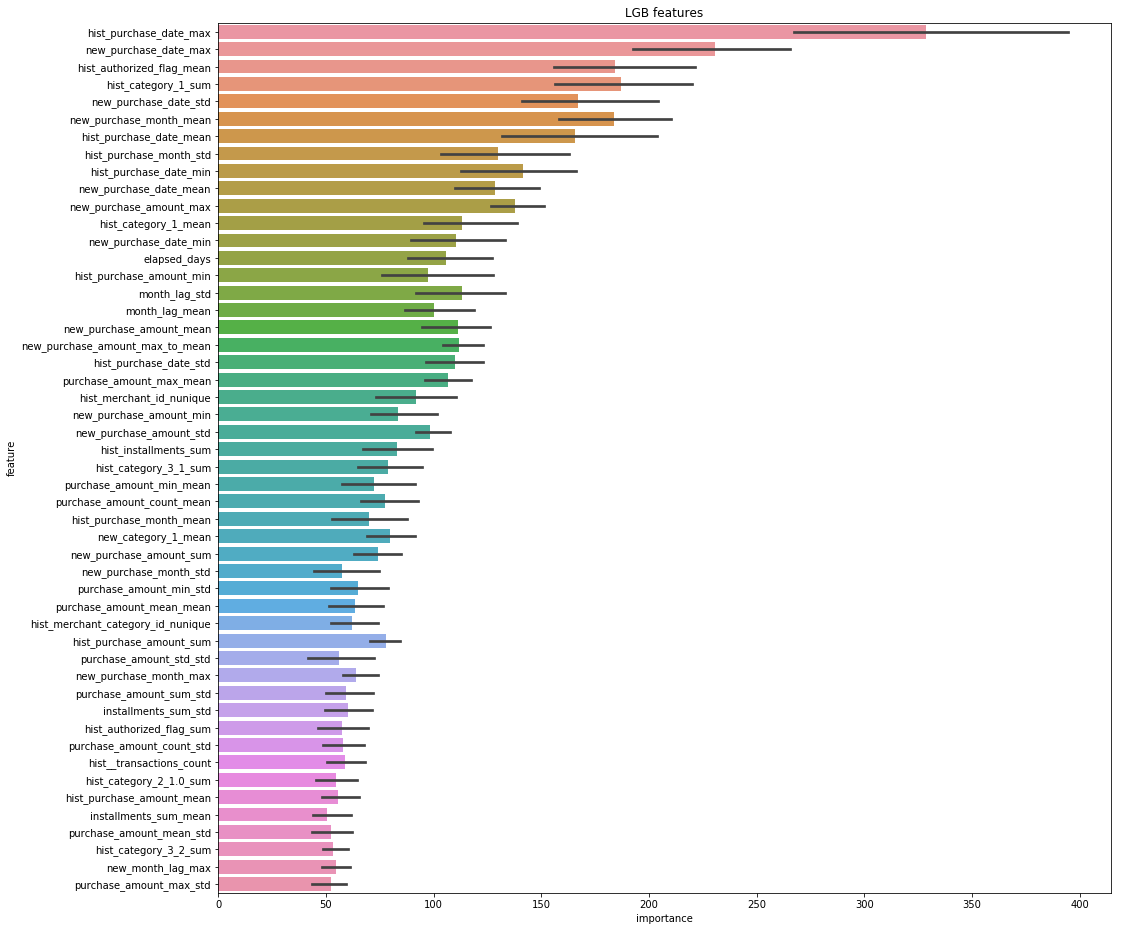

In [122]:
lgb_oof, lgb_predictions, lgb_feature_importance = \
    train_model(params=params, model_type='lgb', plot_feature_importance=True)

In [123]:
submission = pd.read_csv('./inputs/sample_submission.csv')

In [124]:
submission['target'] = lgb_predictions
submission.to_csv('lgb.csv', index=False)

> XGB

In [125]:
xgb_params = {
    'eta': 0.01, 'max_depth': 10, 'subsample': 0.8, 'colsample_bytree': 0.8, 
    'objective': 'reg:linear', 'eval_metric': 'rmse', 'silent': True, 'nthread': 4
}

oof_xgb, prediction_xgb = train_model(params=xgb_params, model_type='xgboost')

Folds: 0 Started at: Mon Dec 24 10:38:03 2018
[0]	Train-rmse:3.93791	Validation-rmse:3.9738
Multiple eval metrics have been passed: 'Validation-rmse' will be used for early stopping.

Will train until Validation-rmse hasn't improved in 200 rounds.
[500]	Train-rmse:2.78969	Validation-rmse:3.6937
Stopping. Best iteration:
[725]	Train-rmse:2.61593	Validation-rmse:3.69216

Folds: 1 Started at: Mon Dec 24 10:51:52 2018
[0]	Train-rmse:3.94178	Validation-rmse:3.96037
Multiple eval metrics have been passed: 'Validation-rmse' will be used for early stopping.

Will train until Validation-rmse hasn't improved in 200 rounds.
[500]	Train-rmse:2.78071	Validation-rmse:3.67403
Stopping. Best iteration:
[557]	Train-rmse:2.7322	Validation-rmse:3.67353

Folds: 2 Started at: Mon Dec 24 11:03:11 2018
[0]	Train-rmse:3.90935	Validation-rmse:4.08646
Multiple eval metrics have been passed: 'Validation-rmse' will be used for early stopping.

Will train until Validation-rmse hasn't improved in 200 rounds.
[500]	

In [126]:
submission['target'] = prediction_xgb
submission.to_csv('xgb.csv', index=False)